In [ ]:
!pip install tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-image


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image


from tqdm import tqdm
import torch
import torch.optim as optim

import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU is available.


In [ ]:
import numpy as np
import cv2

import os
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

class SICEDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.data_folder, image_file)

        # Load image
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if needed

        # Apply transformations if available
        if self.transform:
            image = self.transform(image)

        return image

def Get_Data(data_folder):

    transform = transforms.Compose([ transforms.ToTensor(),])

    # Create the dataset instance
    dataset = SICEDataset(data_folder, transform=transform)

    batch_size = 32

    # Create the data loader
    train_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return train_data_loader

def Extract_Channels(batch,device):
    R = batch[:,0,:,:].unsqueeze(1)
    G = batch[:,1,:,:].unsqueeze(1)
    B  =batch[:,2,:,:].unsqueeze(1)
    RG = torch.cat((R,G),dim=1).to(device)
    RB  = torch.cat((R,B),dim=1).to(device)
    GB = torch.cat((G,B),dim=1).to(device)
    return RG,RB,GB



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class CCNConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CCNConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

class DENConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DENConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

class Channel_Correlation_Network(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(Channel_Correlation_Network, self).__init__()
        self.Block1 = CCNConvBlock(input_channels,64)
        self.Block2 = CCNConvBlock(64,64)
        self.Block3 = CCNConvBlock(64,64)
        self.Block4 = CCNConvBlock(64,64)
        self.Block5 = CCNConvBlock(64,64)
        self.Block6 = CCNConvBlock(128,64)
        self.Block7 = CCNConvBlock(128,64)
        self.Block8 = CCNConvBlock(128,64)
        self.Block9 = CCNConvBlock(128,64)
        self.Block10 = CCNConvBlock(64,64)
        self.Out_Layer = nn.Conv2d(64,output_channels,kernel_size=(3,3),stride=1,padding=1)


    def forward(self,x):
        Encoder_Output = []
        x = self.Block1.forward(x)
        Encoder_Output.append(x)
        x = self.Block2.forward(x)
        Encoder_Output.append(x)
        x = self.Block3.forward(x)
        Encoder_Output.append(x)
        x = self.Block4.forward(x)
        Encoder_Output.append(x)
        x = self.Block5.forward(x)
        x = torch.cat((x,Encoder_Output.pop()),dim=1)
        x = self.Block6.forward(x)
        x = torch.cat((x,Encoder_Output.pop()),dim=1)
        x = self.Block7.forward(x)
        x =torch.cat((x,Encoder_Output.pop()),dim=1)
        x = self.Block8.forward(x)
        x = torch.cat((x,Encoder_Output.pop()),dim=1)
        x = self.Block9.forward(x)
        x = self.Block10.forward(x)
        out = self.Out_Layer.forward(x)
        return out


class Detail_Enhancement_Network(nn.Module):
    def __init__(self,input_channels,device):
        super(Detail_Enhancement_Network, self).__init__()
        self.Block1 = DENConvBlock(input_channels,64)
        self.Block2 = DENConvBlock(64,64)
        self.Block3 = DENConvBlock(64,64)
        self.Block4 = DENConvBlock(64,64)
        self.Out_Layer = nn.Conv2d(64,3,kernel_size=(3,3),stride=1,padding=1)
        self.mean_filter = (torch.ones(3,1,3, 3) / 9.0).to(device)

    def fm(self,image_a):

        self.mean_filter = (torch.ones(3,1,3, 3) / 9.0).to(self.device)  # Dividing by 9 for normalization
        output_image  = F.conv2d(image_a, self.mean_filter,groups=3, padding=1)

        return output_image

    def forward(self,x):

          # Dividing by 9 for normalization

        I_det_fm  = F.conv2d(x, self.mean_filter,groups=3,padding=1)
        I_det = I_det  -I_det_fm
        I_det = self.Block1(I_det)
        I_det = self.Block2(I_det)
        I_det = self.Block3(I_det)
        I_det = self.Block4(I_det)
        I_det = self.Out_Layer(I_det)
        return I_det+x

class Multi_Scale_Feature_Channel_Shuffle(nn.Module):
    def __init__(self,in_channels):
        super(Multi_Scale_Feature_Channel_Shuffle, self).__init__()

       # 1x1 conv branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, 4, kernel_size=(1,1)),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels,4 , kernel_size=(3,3),padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU()

        )

        # 1x1 conv -> 5x5 conv branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels,32 , kernel_size=(3,3),padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,4 , kernel_size=(3,3),padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )

        self.branch7x7 = nn.Sequential(
            nn.Conv2d(in_channels,32 , kernel_size=(3,3),padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32 , kernel_size=(3,3),padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,4 , kernel_size=(3,3),padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )

    def ChannelShuffle(self,x):
        _, _, _, num_channels = x.size()

        # Generate a random permutation of channel indices
        permutation = torch.randperm(num_channels, device=x.device)

        # Shuffle the channels using the permutation
        shuffled_x = x.permute(0, 1, 2, 3)[..., permutation]

        return shuffled_x

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch7x7 = self.branch7x7(x)

        x  = torch.cat([branch1x1,branch3x3,branch5x5,branch7x7],dim=1)
        x = self.ChannelShuffle(x)

        return x

class Multi_Fusion_Network(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Multi_Fusion_Network, self).__init__()
        self.Block1 = Multi_Scale_Feature_Channel_Shuffle(in_channels)
        self.Block2 = Multi_Scale_Feature_Channel_Shuffle(16)
        self.Block3 = Multi_Scale_Feature_Channel_Shuffle(16)
        self.Block4 = Multi_Scale_Feature_Channel_Shuffle(16)
        self.Block5 = Multi_Scale_Feature_Channel_Shuffle(16)
        self.Block6 = Multi_Scale_Feature_Channel_Shuffle(16)
        self.Block7 = Multi_Scale_Feature_Channel_Shuffle(16)
        self.Block8 = Multi_Scale_Feature_Channel_Shuffle(16)

        self.Output_Layer = nn.Conv2d(16,out_channels,kernel_size=(3,3),stride=1,padding=1)

    def forward(self,x):
        x = self.Block1(x)
        x = self.Block2(x)
        x = self.Block3(x)
        x = self.Block4(x)
        x = self.Block5(x)
        x = self.Block6(x)
        x = self.Block7(x)
        x = self.Block8(x)

        x = self.Output_Layer(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CCNLoss(nn.Module):
    def __init__(self, weight_r,weight_c,weight_cr):
        super(CCNLoss, self).__init__()
        self.weight_r = weight_r
        self.weight_c = weight_c
        self.weight_cr = weight_cr
    def angle_difference(self,pixel_a,pixel_b):
        normalized_vector_A = F.normalize(pixel_a, p=2, dim=0)
        normalized_vector_B = F.normalize(pixel_b, p=2, dim=0)

        # Calculate cosine similarity
        cosine_similarity = torch.sum(normalized_vector_A * normalized_vector_B)

        # Clamp the values to avoid numerical instability in arccos
        cosine_similarity = torch.clamp(cosine_similarity, -1.0 + 1e-7, 1.0 - 1e-7)

        # Calculate the angle difference (arccos)
        angle_difference = torch.acos(cosine_similarity)

        return angle_difference
    def color_loss(self,image_a,image_b):
        c_loss=0
        for i in range(image_a.shape[2]):
            for j in range(image_a.shape[3]):
                pixel_a = image_a[:,:,i,j]
                pixel_b = image_b[:,:,i,j]
                angle_diff = self.angle_difference(pixel_a,pixel_b)
                if(i==0 and j==0):
                    c_loss = angle_diff
                else:
                    c_loss +=angle_diff
        return c_loss
    def channel_relevance_map(self,image_a):
        P = image_a[0,:,:].unsqueeze(0)
        Q = image_a[1,:,:].unsqueeze(0)
        P = P.view(-1,P.shape[1],P.shape[2])
        Q = Q.view(-1,P.shape[1],P.shape[2])
        flatten = P.shape[1]*P.shape[2]
        P = P.view(-1,flatten)
        Q = Q.view(-1,flatten)

        Q = torch.transpose(Q,0,1)

        X = torch.matmul(Q,P)
        X = F.softmax(X,dim=0)
        X = torch.mean(X)
        return X
    def channel_correlation_loss(self,image_a,image_b):
        X_pre = self.channel_relevance_map(image_a)
        X_nor = self.channel_relevance_map(image_b)

        cr_loss = torch.abs(X_pre - X_nor)
        return cr_loss
    def reconstruction_loss(self,image_a,image_b):
       criterion = nn.L1Loss(reduction='mean')
       return criterion(image_a,image_b)

    def forward(self, predictions, targets):
        # Your custom loss calculation

        r_loss = self.reconstruction_loss(predictions,targets)
        c_loss = self.color_loss(predictions,targets)
        cr_loss = self.channel_correlation_loss(predictions,targets)
        ccn_loss = self.weight_r*r_loss + self.weight_c*c_loss + self.weight_cr*cr_loss
        return ccn_loss




class MFNLoss(nn.Module):
    def __init__(self, weight_r,weight_c,weight_p,weight_s,device):
        super(MFNLoss, self).__init__()
        self.weight_r = weight_r
        self.weight_c = weight_c
        self.weight_p = weight_p
        self.weight_s = weight_s
        self.device =device
        self.sobel_filter = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3).to(self.device)
        self.kernel_left = torch.tensor([[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=torch.float32).to(self.device)
        self.kernel_right = torch.tensor([[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=torch.float32).to(self.device)
        self.kernel_up = torch.tensor([[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=torch.float32).to(self.device)
        self.kernel_down = torch.tensor([[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=torch.float32).to(self.device)

    def reconstruction_loss(self,image_a,image_b):
       criterion = nn.L1Loss(reduction='mean')
       return criterion(image_a,image_b)


    def angle_difference(self,pixel_a,pixel_b):
        normalized_vector_A = F.normalize(pixel_a, p=2, dim=0)
        normalized_vector_B = F.normalize(pixel_b, p=2, dim=0)

        # Calculate cosine similarity
        cosine_similarity = torch.sum(normalized_vector_A * normalized_vector_B)

        # Clamp the values to avoid numerical instability in arccos
        cosine_similarity = torch.clamp(cosine_similarity, -1.0 + 1e-7, 1.0 - 1e-7)

        # Calculate the angle difference (arccos)
        angle_difference = torch.acos(cosine_similarity)

        return angle_difference
    def color_loss(self,image_a,image_b):
        c_loss=0
        for i in range(image_a.shape[2]):
            for j in range(image_a.shape[3]):
                pixel_a = image_a[:,:,i,j]
                pixel_b = image_b[:,:,i,j]
                angle_diff = self.angle_difference(pixel_a,pixel_b)
                if(i==0 and j==0):
                    c_loss = angle_diff
                else:
                    c_loss += angle_diff
        return c_loss
    def gradient_operator(self,image_a):
        #change the  view according to your batch and channels



# Apply Sobel filter separately to each channel
        R = image_a[0,0,:,:].unsqueeze(0)
        G = image_a[0,1,:,:].unsqueeze(0)
        B = image_a[0,2,:,:].unsqueeze(0)
        gradients_per_r = F.conv2d(R,self. sobel_filter, padding=1)
        gradients_per_g = F.conv2d(G, self.sobel_filter, padding=1)
        gradients_per_b = F.conv2d(B, self.sobel_filter, padding=1)

        # Sum the absolute values of gradients across channels
        return  gradients_per_r,gradients_per_g,gradients_per_b

    def smoothness_loss(self,image_a,image_b):
        gradients_r,gradients_g,gradients_b = self.gradient_operator(image_a)
        gradients_r1,gradients_g1,gradients_b1 = self.gradient_operator(image_b)
        s_loss = torch.sum(torch.abs(gradients_r-gradients_r1)+torch.abs(gradients_g-gradients_g1)+torch.abs(gradients_b-gradients_b1))
        return  s_loss
    def spatial_consistency_loss(self,image_a,image_b):




        enh_image_pooled = F.avg_pool2d(image_a, kernel_size=4, stride=4, padding=0)
        inp_image_pooled = F.avg_pool2d(image_b, kernel_size=4, stride=4, padding=0)

        D_inp_left = F.conv2d(inp_image_pooled, self.kernel_left, stride=1, padding='same')
        D_inp_right = F.conv2d(inp_image_pooled, self.kernel_right, stride=1, padding='same')
        D_inp_up = F.conv2d(inp_image_pooled, self.kernel_up, stride=1, padding='same')
        D_inp_down = F.conv2d(inp_image_pooled, self.kernel_down, stride=1, padding='same')

        D_enh_left = F.conv2d(enh_image_pooled, self.kernel_left, stride=1, padding='same')
        D_enh_right = F.conv2d(enh_image_pooled, self.kernel_right, stride=1, padding='same')
        D_enh_up = F.conv2d(enh_image_pooled, self.kernel_up, stride=1, padding='same')
        D_enh_down = F.conv2d(enh_image_pooled, self.kernel_down, stride=1, padding='same')

        D_left = torch.square(D_inp_left - D_enh_left)
        D_right = torch.square(D_inp_right - D_enh_right)
        D_up = torch.square(D_inp_up - D_enh_up)
        D_down = torch.square(D_inp_down - D_enh_down)

        return torch.mean(D_left + D_right + D_up + D_down)

    def forward(self,predictions,targets):

        r_loss = self.reconstruction_loss(predictions,targets)
        c_loss = self.color_loss(predictions,targets)
        s_loss  =self.smoothness_loss(predictions,targets)
        p_loss = self.spatial_consistency_loss(predictions,targets)

        mfs_loss = self.weight_c*c_loss  +self.weight_r*r_loss + self.weight_p*p_loss + self.weight_s*s_loss
        return mfs_loss

class DENLoss(nn.Module):
    def __init__(self,device):
        super(DENLoss, self).__init__()
        self.device =device

        pass
    def fm(self,image_a):

        self.mean_filter = (torch.ones(3,1,3, 3) / 9.0).to(self.device)  # Dividing by 9 for normalization
        output_image  = F.conv2d(image_a, self.mean_filter,groups=3, padding=1)


        return output_image

    def forward(self,prediction,targets):
        B = (targets-self.fm(targets))
        criterion = nn.L1Loss(reduction='mean')
        den_loss = criterion(prediction,B)
        return den_loss




In [ ]:

class Low_light_image_enhancement():
    def __init__(self,ccn_weight_r,ccn_weight_c,ccn_weight_cr,mfn_weight_r,mfn_weight_c,mfn_weight_p,mfn_weight_s,lr,device):

        self.CCN = Channel_Correlation_Network(2,2).to(device)
        self.MFN = Multi_Fusion_Network(2,2).to(device)
        self.DEN = Detail_Enhancement_Network(3,device).to(device)
        self.parameters = list(self.CCN.parameters()) + list(self.MFN.parameters()) + list(self.DEN.parameters())
        self.ccn_criterion = CCNLoss(ccn_weight_r,ccn_weight_c,ccn_weight_cr).to(device)
        self.optimizer = optim.Adam(self.parameters, lr=lr)
        self.device = device

        self.mfn_criterion = MFNLoss(mfn_weight_r,mfn_weight_c,mfn_weight_p,mfn_weight_s,device).to(device)

        self.den_criterion = DENLoss(device).to(device)


    def Train(self,epochs,train_data_loader,save_model):
      Mse_line =[]
      Psnr_line = []
      Ssim_line = []
      Epoch =[]
      for epoch in tqdm(range(epochs)):
        MSE = 0.0
        PSNR=0.0
        SSIM=0.0
        Epoch.append(epoch)
        for batch in train_data_loader:

            batch =batch.to(self.device)

            RG,GB,RB  = Extract_Channels(batch,self.device)

            RG_1 = self.CCN(RG)
            GB_1 = self.CCN(GB)
            RB_1 = self.CCN(RB)

            ccnl1 = self.ccn_criterion(RG,RG_1)
            ccnl2= self.ccn_criterion(RB,RB_1)
            ccnl3 = self.ccn_criterion(GB,GB_1)
            ccn_loss = ccnl1 + ccnl2 + ccnl3




            w_rb =self.MFN(RB_1)
            w_gb =self.MFN(GB_1)
            w_rg =self.MFN(RG_1)
            A = torch.matmul(w_rb,RB_1)
            B = torch.matmul(w_gb,GB_1)
            C = torch.matmul(w_rg,RG_1)
            R_fus = A[:,0,:,:].unsqueeze(1) + C[:,0,:,:].unsqueeze(1)
            G_fus = B[:,0,:,:].unsqueeze(1) + C[:,1,:,:].unsqueeze(1)
            B_fus = A[:,1,:,:].unsqueeze(1) + B[:,1,:,:].unsqueeze(1)
            I_fus = torch.cat([R_fus,G_fus,B_fus],dim=1)

            mfn_loss = self.mfn_criterion(I_fus,batch)


            I_enh = self.DEN(I_fus)
            den_loss = self.den_criterion(I_enh,batch)
            # Loss = ccn_loss+mfn_loss+den_loss
            self.optimizer.zero_grad()  # Clear previous gradients
            # Loss.backward()
            ccn_loss.backward(retain_graph=True)
            mfn_loss.backward(retain_graph=True)
            den_loss.backward()
            self.optimizer.step()
            I_enh = I_enh.cpu()
            batch = batch.cpu()
            RG=RG.cpu()
            GB=GB.cpu()
            RB=RB.cpu()
            mse = F.mse_loss(batch, I_enh).item()
            psnr_value = psnr(batch.detach().numpy(),I_enh.detach().numpy())
            ssim_value, _ = ssim(batch.detach().numpy(),I_enh.detach().numpy(), full=True,channel_axis=1)
            MSE +=mse
            PSNR +=psnr_value
            SSIM +=ssim_value

        MSE/=len(train_data_loader)
        PSNR/=len(train_data_loader)
        SSIM/=len(train_data_loader)
        Mse_line.append(MSE)
        Psnr_line.append(PSNR)
        Ssim_line.append(SSIM)

      # Plotting the line with customization
      plt.plot(Epoch, Mse_line, linestyle='--', marker='o', color='b', label='Custom Line')
      plt.xlabel('Epoch')
      plt.ylabel('Avg Mse')
      plt.title('Avg MSE vs Epoch')
      plt.show()

      plt.plot(Epoch, Psnr_line, linestyle='--', marker='o', color='b', label='Custom Line')
      plt.xlabel('Epoch')
      plt.ylabel('Avg PSNR')
      plt.title('Avg PSNR vs Epoch')
      plt.show()

      plt.plot(Epoch, Ssim_line, linestyle='--', marker='o', color='b', label='Custom Line')
      plt.xlabel('Epoch')
      plt.ylabel('Avg SSIM')
      plt.title('Avg SSIM vs Epoch')
      plt.show()
      if(save_model):
        print("MSE : ",MSE," PSNR : ",PSNR," SSIM : ",SSIM)
        torch.save(self.CCN.state_dict(), 'ccn_weights.pth')
        torch.save(self.MFN.state_dict(), 'mfn_weights.pth')
        torch.save(self.DEN.state_dict(), 'den_weights.pth')



    def load_model(self):
      self.CCN.load_state_dict(torch.load('ccn_weights.pth'))
      self.MFN.load_state_dict(torch.load('mfn_weights.pth'))
      self.DEN.load_state_dict(torch.load('den_weights.pth'))



    def Test(self,img_tensor):

      img_array = img_tensor.permute(1, 2, 0).numpy()

      # Display the image using matplotlib
      plt.imshow(img_array)
      plt.axis('off')  # Turn off axis labels
      plt.show()

      batch = img_tensor.unsqueeze(0).to(self.device)

      RG,GB,RB  = Extract_Channels(batch,self.device)

      RG_1 = self.CCN(RG)
      GB_1 = self.CCN(GB)
      RB_1 = self.CCN(RB)




      w_rb =self.MFN(RB_1)
      w_gb =self.MFN(GB_1)
      w_rg =self.MFN(RG_1)
      A = torch.matmul(w_rb,RB_1)
      B = torch.matmul(w_gb,GB_1)
      C = torch.matmul(w_rg,RG_1)
      R_fus = A[:,0,:,:].unsqueeze(1) + C[:,0,:,:].unsqueeze(1)
      G_fus = B[:,0,:,:].unsqueeze(1) + C[:,1,:,:].unsqueeze(1)
      B_fus = A[:,1,:,:].unsqueeze(1) + B[:,1,:,:].unsqueeze(1)
      I_fus = torch.cat([R_fus,G_fus,B_fus],dim=1)
      I_enh = self.DEN(I_fus)
      I_enh=I_enh[0].cpu().detach()
      mean = torch.mean(I_enh)
      std = torch.std(I_enh)
      image_tensor = (I_enh - mean) / std
      # img_tensor = I_enh.clamp(0, 1)
      img_array = img_tensor.permute(1, 2, 0).numpy()

      # Display the image using matplotlib
      plt.imshow(img_array)
      plt.axis('off')  # Turn off axis labels
      plt.show()







In [ ]:
data_folder = '/content/drive/MyDrive/Train_Data'

train_data_loader = Get_Data(data_folder)

100%|██████████| 35/35 [24:06<00:00, 41.34s/it]


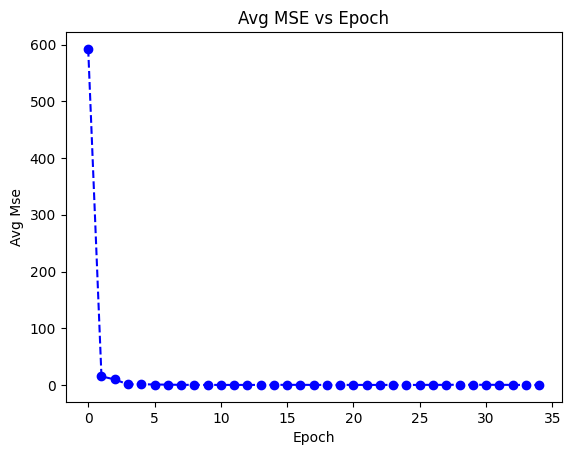

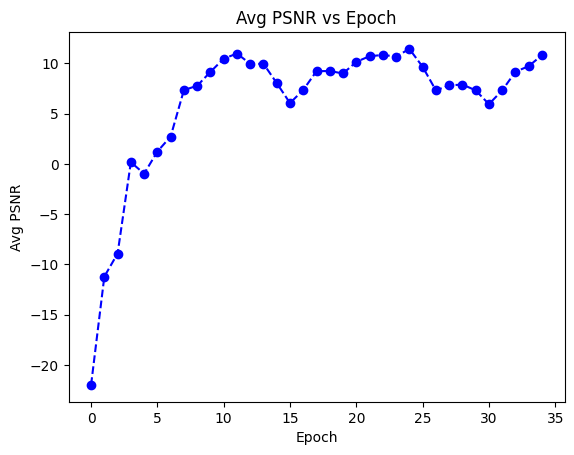

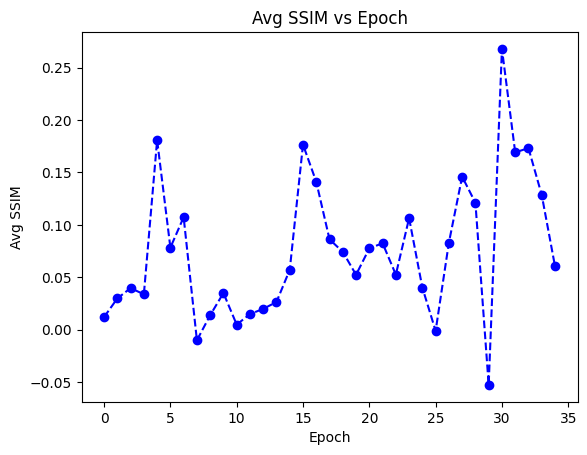

MSE :  0.08660830402125914  PSNR :  10.836925741511712  SSIM :  0.06052616021285454


In [ ]:

ccn_weight_r=1.0
ccn_weight_c=0.7
ccn_weight_cr=1.0
mfn_weight_r=0.1
mfn_weight_c=5
mfn_weight_p=3
mfn_weight_s=1.0
lr=0.001
save_model  =True
epochs=35
Model = Low_light_image_enhancement(ccn_weight_r,ccn_weight_c,ccn_weight_cr,mfn_weight_r,mfn_weight_c,mfn_weight_p,mfn_weight_s,lr,device)
Model.Train(epochs,train_data_loader,save_model)




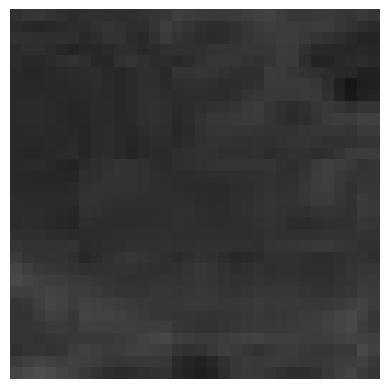

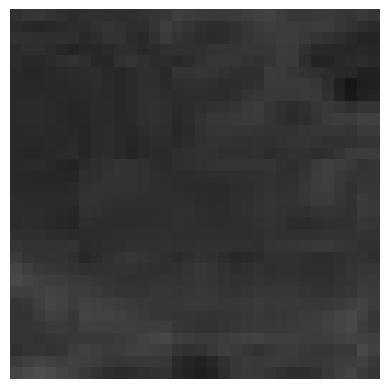

In [ ]:
Model.load_model()



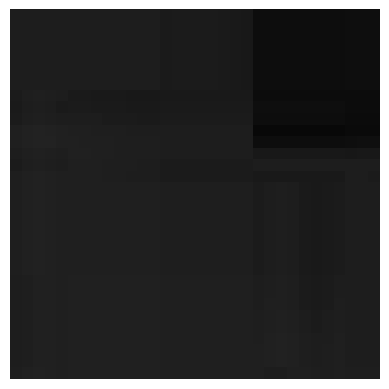

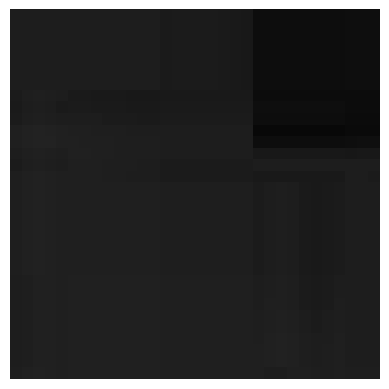

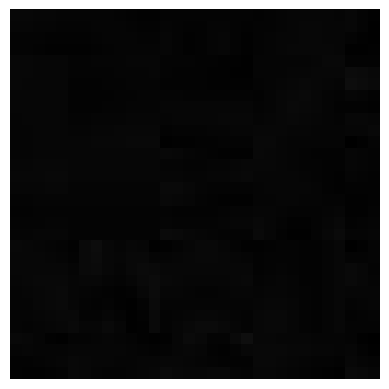

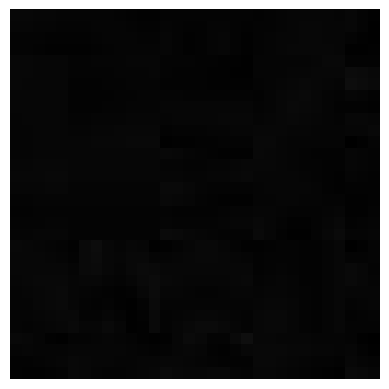

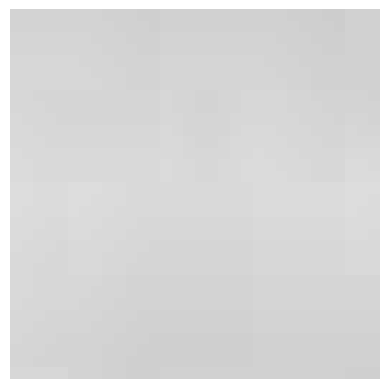

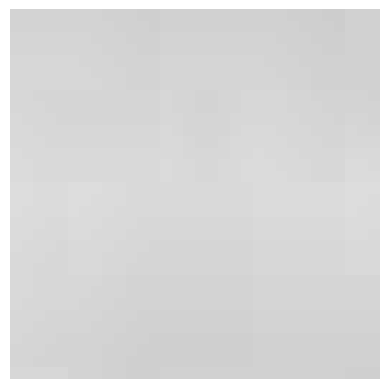

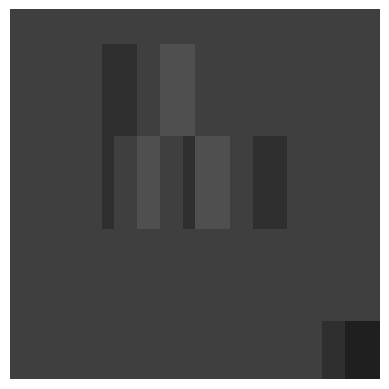

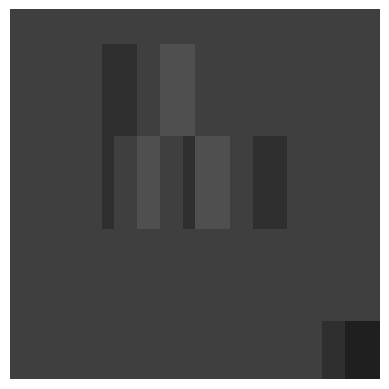

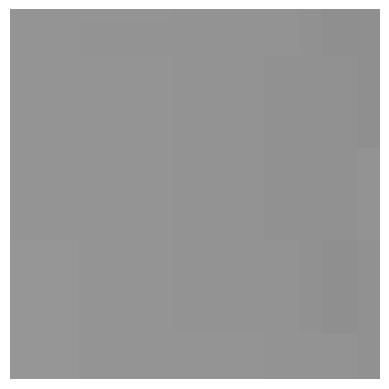

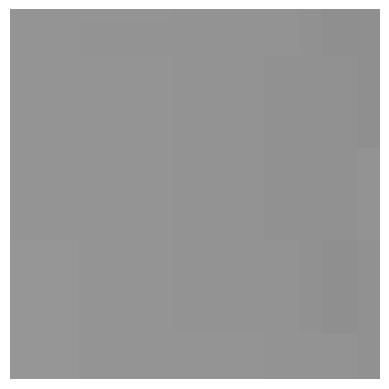

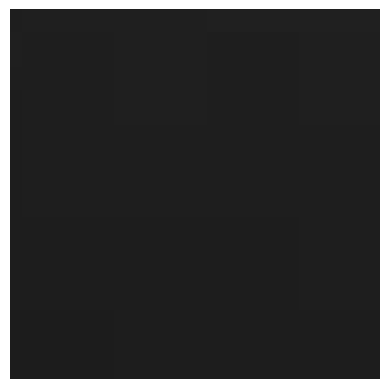

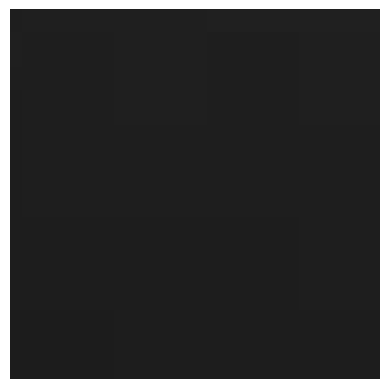

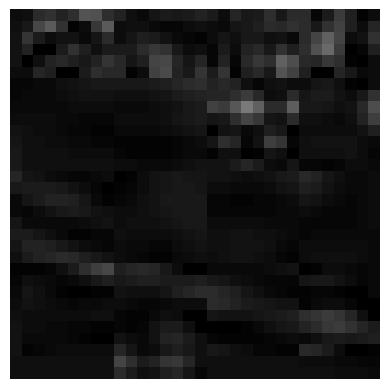

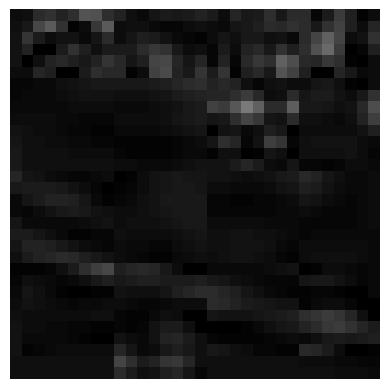

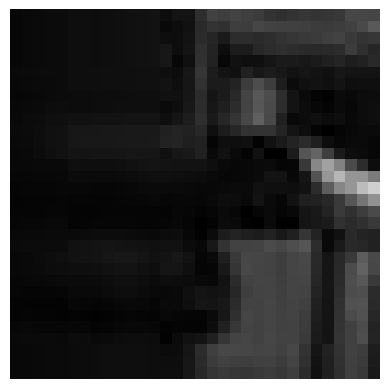

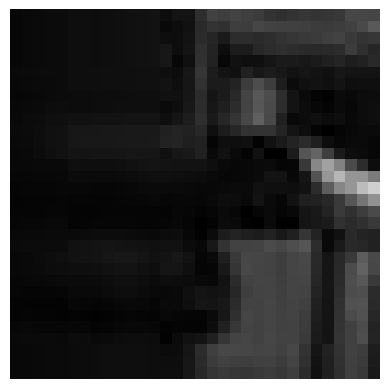

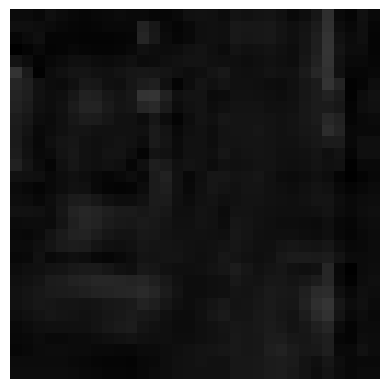

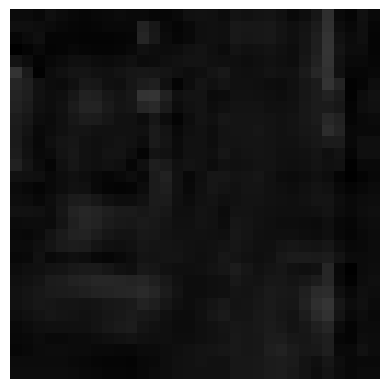

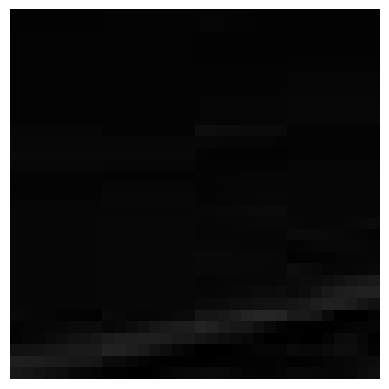

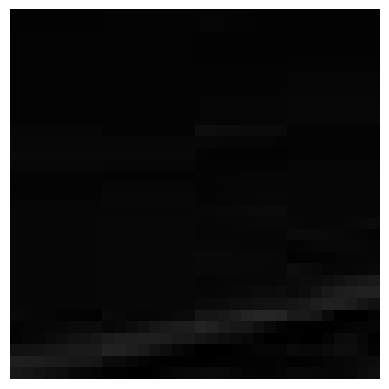

In [ ]:
ind =0
for batch in train_data_loader:
    img  =batch[0]

    Model.Test(img)
    ind+=1
    if(ind==10):
      break

In [ ]:
Model.load_model()

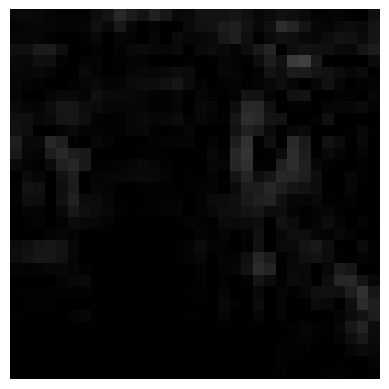

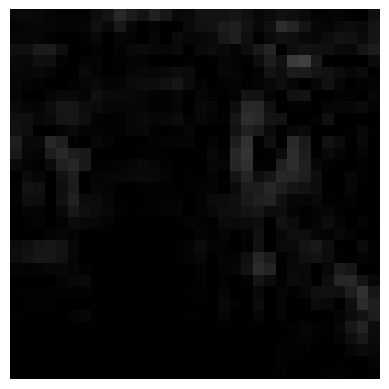

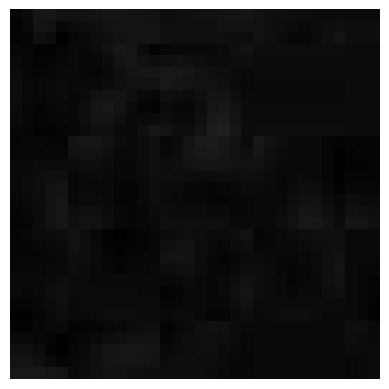

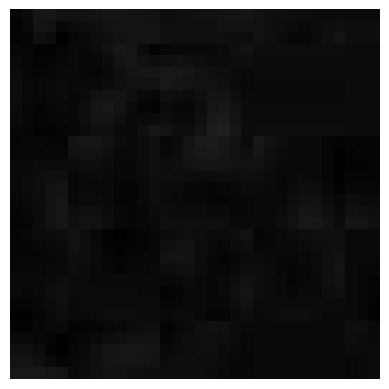

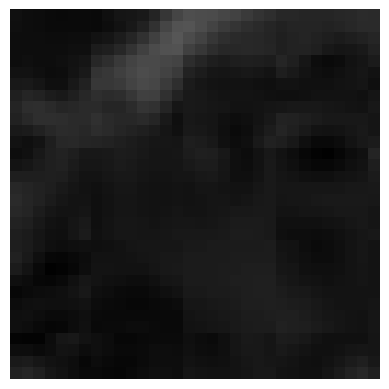

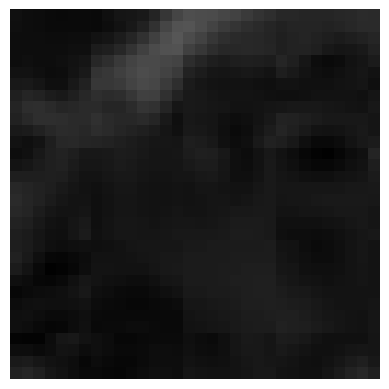

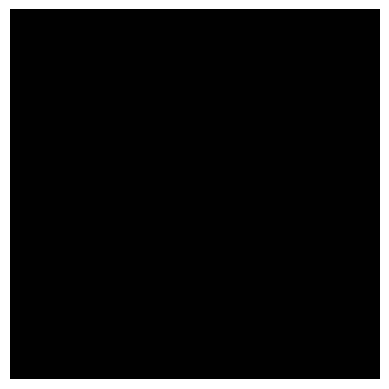

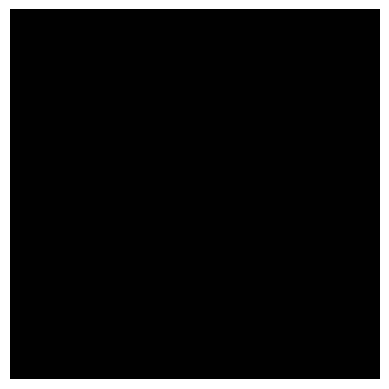

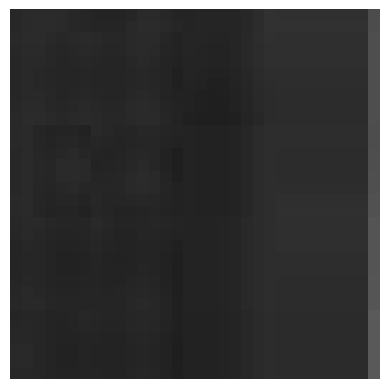

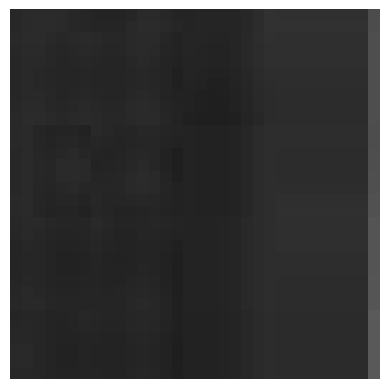

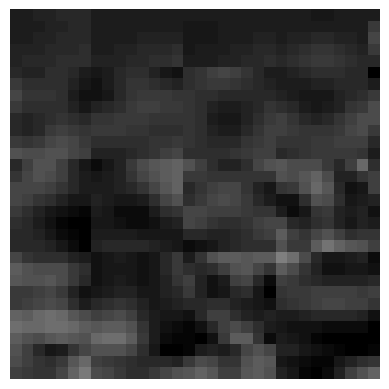

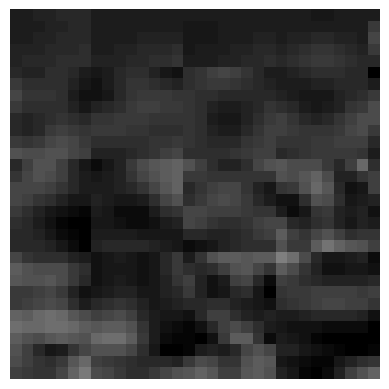

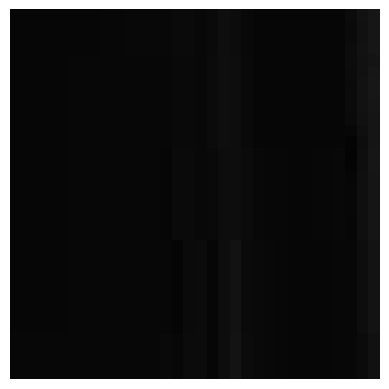

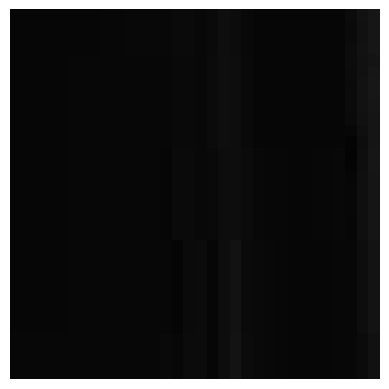

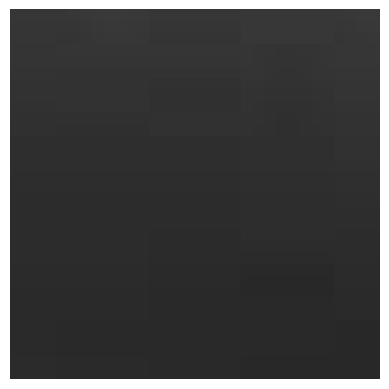

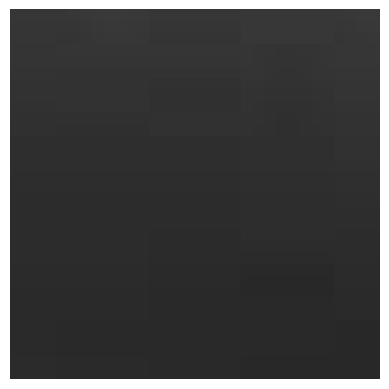

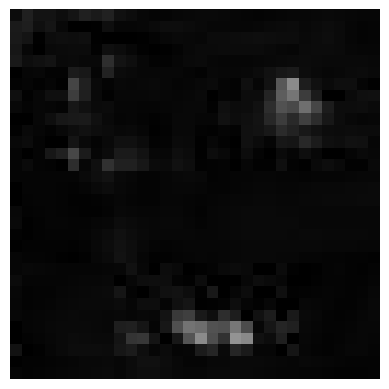

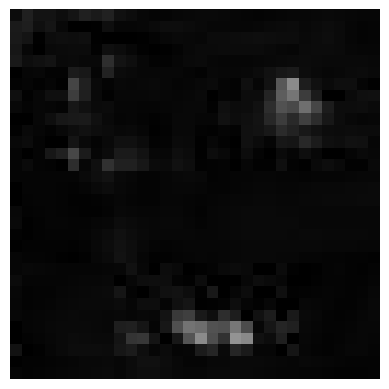

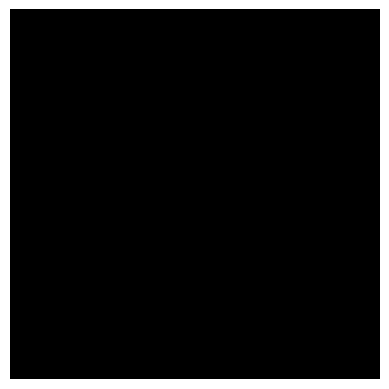

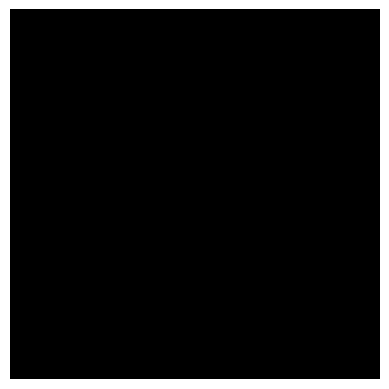

In [ ]:
ind =0
for batch in train_data_loader:
    img  =batch[0]

    Model.Test(img)
    ind+=1
    if(ind==10):
      break